In [6]:
#!pip install tldextract catboost

In [7]:
import re
import numpy as np
import pandas as pd
import tldextract
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV  # ✅ Import GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier   # ✅ Import LightGBM
from catboost import CatBoostClassifier  # ✅ Import CatBoost
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [8]:
def extract_url_features(url):
    """
    Extracts numerical features from a given URL for phishing detection.
    :param url: Raw URL string.
    :return: List of numerical features.
    """
    parsed_url = urlparse(url)
    domain_info = tldextract.extract(url)

    features = []

    # 🚀 1️⃣ Basic URL properties
    features.append(len(url))  # Length of URL
    features.append(len(parsed_url.netloc))  # Length of domain name
    features.append(len(parsed_url.path))  # Length of URL path

    # 🚀 2️⃣ Special character counts
    features.append(url.count('.'))  # Number of dots in URL
    features.append(url.count('-'))  # Number of hyphens
    features.append(url.count('/'))  # Number of slashes
    features.append(url.count('?'))  # Number of '?'
    features.append(url.count('&'))  # Number of '&'
    features.append(url.count('='))  # Number of '='

    # 🚀 3️⃣ Domain-related features
    features.append(1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) else 0)  # IP address?
    features.append(1 if domain_info.suffix in ["xyz", "tk", "ml", "ga", "cf"] else 0)  # Suspicious TLD?

    return features

In [9]:
# Load dataset (only URL & status columns)
df = pd.read_csv("dataset_phishing.csv", usecols=["url", "status"])

# Convert 'status' column to numeric (0 = Legitimate, 1 = Phishing)
df['status'] = df['status'].map({'legitimate': 0, 'phishing': 1})

# Extract Features for Each URL
df_features = df['url'].apply(extract_url_features)
df_features = pd.DataFrame(df_features.tolist())

# Rename columns
df_features.columns = [
    "length_url", "length_hostname", "length_path", "nb_dots", "nb_hyphens",
    "nb_slash", "nb_qm", "nb_and", "nb_eq", "has_ip_address", "suspicious_tld",
]


# Add target variable (status)
df_features['status'] = df['status']

# Display first few rows
print(df_features.head())



   length_url  length_hostname  length_path  nb_dots  nb_hyphens  nb_slash  \
0          37               19           11        3           0         3   
1          77               23           47        1           0         5   
2         126               50           20        4           1         5   
3          18               11            0        2           0         2   
4          55               15           33        2           2         5   

   nb_qm  nb_and  nb_eq  has_ip_address  suspicious_tld  status  
0      0       0      0               0               0       0  
1      0       0      0               0               0       1  
2      1       2      3               0               0       1  
3      0       0      0               0               0       0  
4      0       0      0               0               0       0  


In [10]:
#Step 2
# Split dataset into features (X) and target (y)
X = df_features.drop(columns=["status"])  # Feature set
y = df_features["status"]  # Target variable

# Split dataset into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame with correct feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [11]:
#Step 3
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Train LGM
# Train CatBoost
lgb_model = LGBMClassifier()
cat_model = CatBoostClassifier(silent=True)


# ✅ Train LightGBM & CatBoost with Feature Names
lgb_model.fit(X_train_scaled, y_train)
cat_model.fit(X_train_scaled, y_train)


[LightGBM] [Info] Number of positive: 3829, number of negative: 3829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 7658, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [12]:
#BERT IMPLEMENTATION ; Step 6

# Check Apple MPS support (for MacBook Pro M3)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS for acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA for acceleration")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Load dataset
df_bert = pd.read_csv("/content/dataset_phishing.csv", usecols=["url", "status"])
df_bert["status"] = df_bert["status"].map({"legitimate": 0, "phishing": 1})

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_bert["url"].values, df_bert["status"].values, test_size=0.33 ,random_state=42, stratify=df_bert["status"]
)

train_texts = train_texts.tolist()
test_texts = test_texts.tolist()

Using CUDA for acceleration


In [13]:
#step 7
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Custom dataset class
class URLDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create dataset instances
train_dataset = URLDataset(train_texts, train_labels, tokenizer)
test_dataset = URLDataset(test_texts, test_labels, tokenizer)

# DataLoader for efficiency
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load BERT model for classification
model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_bert.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model_bert.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Step 8
#Training function
def train_model(model_bert, train_loader, optimizer, criterion, epochs=3):
    model_bert.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0  # Initialize correct predictions
        total_samples = 0  # Initialize total samples

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model_bert(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits  # Extract logits

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute accuracy
            preds = torch.argmax(logits, dim=1)  # Get predicted labels
            correct_predictions += (preds == labels).sum().item()  # Count correct predictions
            total_samples += labels.size(0)  # Total number of samples

        # Compute loss and accuracy for the epoch
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples  # Compute accuracy

        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

# Call training function
train_model(model_bert, train_loader, optimizer, criterion, epochs=3)

Epoch 1: Loss = 0.2626, Accuracy = 0.8950
Epoch 2: Loss = 0.1109, Accuracy = 0.9608
Epoch 3: Loss = 0.0557, Accuracy = 0.9815


In [15]:
#step 9 : Evaluation function of all models

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

def evaluate_model_combined(model, X_test, y_test, model_name, is_bert=False, show_cm=True):
    """
    Unified evaluation function for ML, DL, and BERT models.
    Args:
        model: The trained model to evaluate
        X_test: Test input (DataFrame, numpy array, or DataLoader)
        y_test: True labels (list, np.array, or torch.Tensor)
        model_name: Name of the model for display
        is_bert: Set True if the model is a BERT model using DataLoader
        show_cm: Show confusion matrix (default=True)
    Returns:
        Dictionary with evaluation metrics
    """
    if is_bert:
        model.eval()
        predictions, true_labels = [], []

        with torch.no_grad():
            for batch in X_test:  # X_test is test_loader here
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)

                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        y_pred = predictions
        y_true = true_labels

    else:
        # Handle deep learning model with probabilities
        if model_name == "Deep Learning":
            y_pred = model.predict(X_test)
            y_pred = (y_pred > 0.5).astype(int).flatten()
        else:
            if not isinstance(X_test, pd.DataFrame):
                X_test = pd.DataFrame(X_test, columns=X.columns)
            y_pred = model.predict(X_test)

        y_true = y_test

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n🔹 {model_name} Performance:")
    print(f"✅ Accuracy:  {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall:    {recall:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")
    print("Classification Report:\n", classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    if show_cm:
        plt.figure(figsize=(5, 5))
        plot_confusion_matrix(cm, figsize=(5, 5), cmap="Blues")
        plt.title(f"{model_name} Confusion Matrix")
        plt.show()

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }




🔹 Random Forest Performance:
✅ Accuracy:  0.6026
✅ Precision: 0.6726
✅ Recall:    0.6026
✅ F1 Score:  0.5578
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.92      0.70      1886
           1       0.78      0.28      0.42      1886

    accuracy                           0.60      3772
   macro avg       0.67      0.60      0.56      3772
weighted avg       0.67      0.60      0.56      3772

Confusion Matrix:
 [[1737  149]
 [1350  536]]


<Figure size 500x500 with 0 Axes>

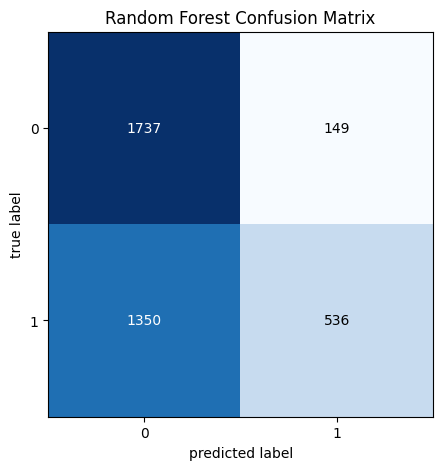


🔹 Logistic Regression Performance:
✅ Accuracy:  0.5191
✅ Precision: 0.7481
✅ Recall:    0.5191
✅ F1 Score:  0.3748
Classification Report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68      1886
           1       0.99      0.04      0.07      1886

    accuracy                           0.52      3772
   macro avg       0.75      0.52      0.37      3772
weighted avg       0.75      0.52      0.37      3772

Confusion Matrix:
 [[1885    1]
 [1813   73]]


<Figure size 500x500 with 0 Axes>

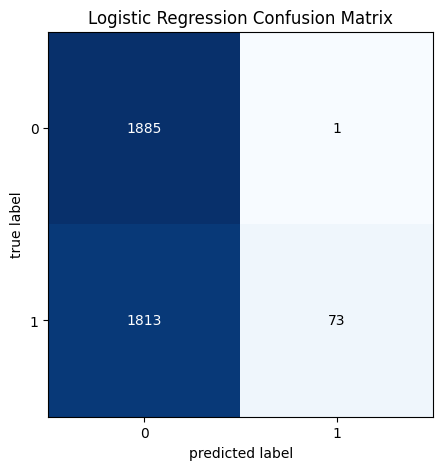


🔹 LightGBM Performance:
✅ Accuracy:  0.7977
✅ Precision: 0.7984
✅ Recall:    0.7977
✅ F1 Score:  0.7976
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80      1886
           1       0.81      0.77      0.79      1886

    accuracy                           0.80      3772
   macro avg       0.80      0.80      0.80      3772
weighted avg       0.80      0.80      0.80      3772

Confusion Matrix:
 [[1549  337]
 [ 426 1460]]


<Figure size 500x500 with 0 Axes>

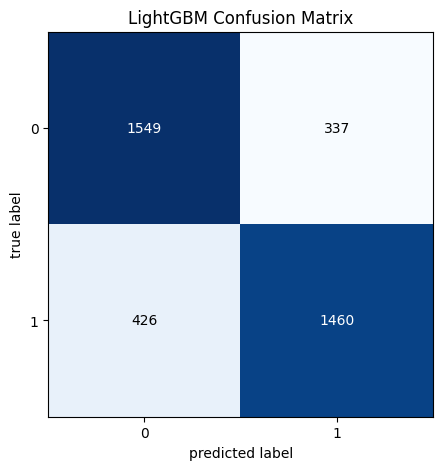


🔹 XGBoost Performance:
✅ Accuracy:  0.5361
✅ Precision: 0.6239
✅ Recall:    0.5361
✅ F1 Score:  0.4361
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.96      0.67      1886
           1       0.73      0.12      0.20      1886

    accuracy                           0.54      3772
   macro avg       0.62      0.54      0.44      3772
weighted avg       0.62      0.54      0.44      3772

Confusion Matrix:
 [[1805   81]
 [1669  217]]


<Figure size 500x500 with 0 Axes>

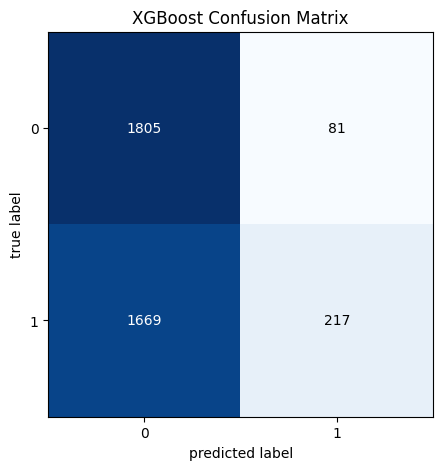


🔹 CatBoost Performance:
✅ Accuracy:  0.8033
✅ Precision: 0.8043
✅ Recall:    0.8033
✅ F1 Score:  0.8031
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      1886
           1       0.82      0.77      0.80      1886

    accuracy                           0.80      3772
   macro avg       0.80      0.80      0.80      3772
weighted avg       0.80      0.80      0.80      3772

Confusion Matrix:
 [[1570  316]
 [ 426 1460]]


<Figure size 500x500 with 0 Axes>

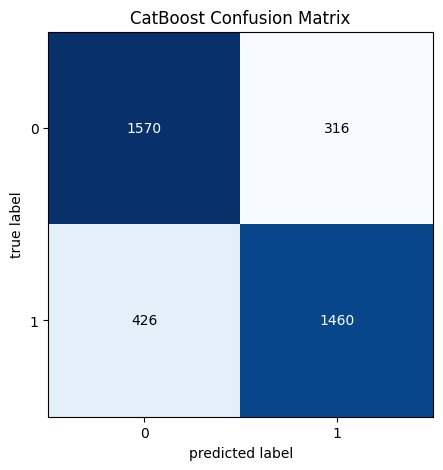


🔹 BERT Performance:
✅ Accuracy:  0.9510
✅ Precision: 0.9510
✅ Recall:    0.9510
✅ F1 Score:  0.9510
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      1886
           1       0.95      0.95      0.95      1886

    accuracy                           0.95      3772
   macro avg       0.95      0.95      0.95      3772
weighted avg       0.95      0.95      0.95      3772

Confusion Matrix:
 [[1800   86]
 [  99 1787]]


<Figure size 500x500 with 0 Axes>

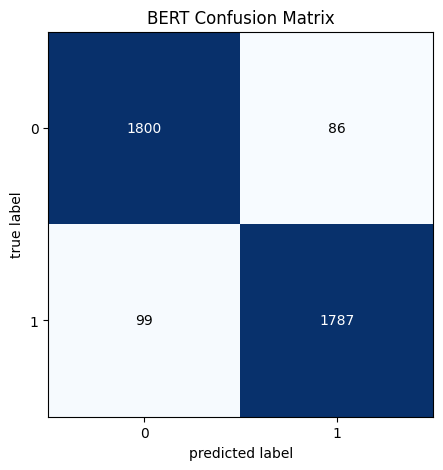

In [16]:
#Model Evaluations : Step 10

#  Random Forest
rf_metrics = evaluate_model_combined(rf_model, X_test_scaled, y_test, "Random Forest")

#  Logistic Regression
log_reg_metrics = evaluate_model_combined(log_reg, X_test_scaled, y_test, "Logistic Regression")

#  LightGBM
lgb_metrics = evaluate_model_combined(lgb_model, X_test_scaled, y_test, "LightGBM")

# XGBoost
xgb_metrics = evaluate_model_combined(xgb_model, X_test_scaled, y_test, "XGBoost")

# CatBoost
cat_metrics = evaluate_model_combined(cat_model, X_test_scaled, y_test, "CatBoost")

#  BERT (uses test_loader)
bert_metrics = evaluate_model_combined(model_bert, test_loader, None, "BERT", is_bert=True)




🔹 Fusion Model (Hard Voting):
Accuracy : 0.6397
Precision: 0.9697
Recall   : 0.2884
F1 Score : 0.4446

🔹 Fusion Model (Weighted Soft Voting):
Accuracy : 0.8945
Precision: 0.9610
Recall   : 0.8224
F1 Score : 0.8863

✅ Selected: Weighted Soft Voting as fusion_model_url


<Figure size 500x500 with 0 Axes>

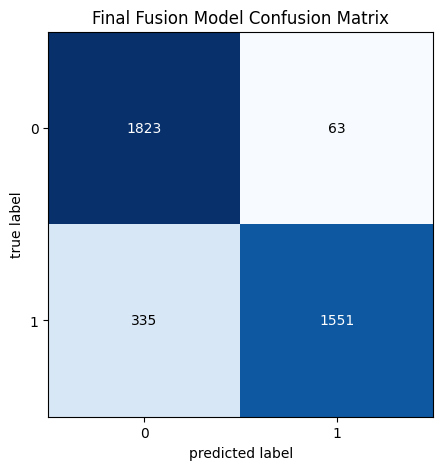

In [18]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

# ✅ BERT Wrapper
class BERTWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def fit(self, X, y): return self

    def predict(self, X, batch_size=16):
        if isinstance(X, np.ndarray): X = X.tolist()
        self.model.eval()
        preds = []
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size]
            inputs = self.tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(self.device)
            with torch.no_grad():
                outputs = self.model(inputs["input_ids"], attention_mask=inputs["attention_mask"])
                preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        return np.array(preds)

    def predict_proba(self, X, batch_size=16):
        if isinstance(X, np.ndarray): X = X.tolist()
        self.model.eval()
        probs = []
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size]
            inputs = self.tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(self.device)
            with torch.no_grad():
                logits = self.model(inputs["input_ids"], attention_mask=inputs["attention_mask"]).logits
                batch_probs = torch.softmax(logits, dim=1)[:, 1]
                probs.extend(batch_probs.cpu().numpy())
        return np.array(probs)

# ✅ Instantiate wrappers

bert_wrapper = BERTWrapper(model_bert, tokenizer, device)

# ✅ Individual Predictions
pred_lr   = log_reg.predict(X_test_scaled)
pred_rf   = rf_model.predict(X_test_scaled)
pred_xgb  = xgb_model.predict(X_test_scaled)
pred_lgb  = lgb_model.predict(X_test_scaled)
pred_cat  = cat_model.predict(X_test_scaled)
pred_bert = bert_wrapper.predict(test_texts)

# ✅ Manual Hard Voting (Fusion)
all_preds = np.array([pred_lr, pred_rf, pred_xgb, pred_lgb, pred_cat, pred_bert])
fusion_preds_hard = np.round(np.mean(all_preds, axis=0)).astype(int)

# ✅ Probabilities for Soft Voting
proba_lr   = log_reg.predict_proba(X_test_scaled)[:, 1]
proba_rf   = rf_model.predict_proba(X_test_scaled)[:, 1]
proba_xgb  = xgb_model.predict_proba(X_test_scaled)[:, 1]
proba_lgb  = lgb_model.predict_proba(X_test_scaled)[:, 1]
proba_cat  = cat_model.predict_proba(X_test_scaled)[:, 1]
proba_bert = bert_wrapper.predict_proba(test_texts)

# ✅ F1-score based Weights
weights = {
    "lr":   f1_score(y_test, pred_lr),
    "rf":   f1_score(y_test, pred_rf),
    "xgb":  f1_score(y_test, pred_xgb),
    "lgb":  f1_score(y_test, pred_lgb),
    "cat":  f1_score(y_test, pred_cat),
    "bert": f1_score(y_test, pred_bert)
}

# ✅ Weighted Soft Voting Fusion
weighted_sum = (
    weights["lr"]   * proba_lr +
    weights["rf"]   * proba_rf +
    weights["xgb"]  * proba_xgb +
    weights["lgb"]  * proba_lgb +
    weights["cat"]  * proba_cat +
    weights["bert"] * proba_bert
)
avg_probs = weighted_sum / sum(weights.values())
fusion_preds_soft = (avg_probs >= 0.5).astype(int)

# ✅ Evaluation — Hard Voting
print("\n🔹 Fusion Model (Hard Voting):")
print(f"Accuracy : {accuracy_score(y_test, fusion_preds_hard):.4f}")
print(f"Precision: {precision_score(y_test, fusion_preds_hard):.4f}")
print(f"Recall   : {recall_score(y_test, fusion_preds_hard):.4f}")
f1_hard = f1_score(y_test, fusion_preds_hard)
print(f"F1 Score : {f1_hard:.4f}")

# ✅ Evaluation — Weighted Soft Voting
print("\n🔹 Fusion Model (Weighted Soft Voting):")
print(f"Accuracy : {accuracy_score(y_test, fusion_preds_soft):.4f}")
print(f"Precision: {precision_score(y_test, fusion_preds_soft):.4f}")
print(f"Recall   : {recall_score(y_test, fusion_preds_soft):.4f}")
f1_soft = f1_score(y_test, fusion_preds_soft)
print(f"F1 Score : {f1_soft:.4f}")

# ✅ Select best fusion strategy
if f1_soft >= f1_hard:
    fusion_model_url = fusion_preds_soft
    print("\n✅ Selected: Weighted Soft Voting as fusion_model_url")
else:
    fusion_model_url = fusion_preds_hard
    print("\n✅ Selected: Hard Voting as fusion_model_url")

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, fusion_model_url)
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cm, figsize=(5, 5), cmap="Blues")
plt.title("Final Fusion Model Confusion Matrix")
plt.show()

In [21]:
import os
import joblib
import torch
import numpy as np

# ✅ Create folders
os.makedirs("models/traditional", exist_ok=True)
os.makedirs("models/deep", exist_ok=True)
os.makedirs("models/bert", exist_ok=True)
os.makedirs("models/fusion", exist_ok=True)

# ✅ Save Traditional Models
joblib.dump(log_reg,  "models/traditional/log_reg_model.pkl")
joblib.dump(rf_model, "models/traditional/rf_model.pkl")
joblib.dump(xgb_model,"models/traditional/xgb_model.pkl")
joblib.dump(lgb_model,"models/traditional/lgb_model.pkl")
joblib.dump(cat_model,"models/traditional/cat_model.pkl")
print("✅ Saved all traditional models")

# ✅ Save Scaler
joblib.dump(scaler, "models/traditional/feature_scaler.pkl")
print("✅ Saved scaler")


# ✅ Save BERT Model + Tokenizer
try:
    model_bert.save_pretrained("models/bert/")
    tokenizer.save_pretrained("models/bert/")
    print("✅ Saved BERT model and tokenizer")
except Exception as e:
    print("❌ Failed to save BERT model:", e)
    torch.save(model_bert.state_dict(), "models/bert/bert_model_weights.pt")
    print("✅ Saved fallback BERT weights manually")

# ✅ Create reusable fusion model object and save
f1_weights_url = {
    "lr":   f1_score(y_test, pred_lr),
    "rf":   f1_score(y_test, pred_rf),
    "xgb":  f1_score(y_test, pred_xgb),
    "lgb":  f1_score(y_test, pred_lgb),
    "cat":  f1_score(y_test, pred_cat),

    "bert": f1_score(y_test, pred_bert)
}

# ✅ Bundle traditional models
url_models = {
    "lr": log_reg,
    "rf": rf_model,
    "xgb": xgb_model,
    "lgb": lgb_model,
    "cat": cat_model
}

# ✅ Define class (if not already defined above)
class URLFusionModel:
    def __init__(self, traditional_models, bert_model, tokenizer, scaler, f1_weights, device, max_length=100):
        self.models = traditional_models
        self.bert_model = bert_model
        self.tokenizer = tokenizer
        self.scaler = scaler
        self.f1_weights = f1_weights
        self.device = device
        self.max_length = max_length

    def _extract_url_features(self, urls):
        features = []
        for url in urls:
            parsed_url = urlparse(url)
            domain_info = tldextract.extract(url)
            features.append([
                len(url),
                len(parsed_url.netloc),
                len(parsed_url.path),
                url.count('.'),
                url.count('-'),
                url.count('/'),
                url.count('?'),
                url.count('&'),
                url.count('='),
                1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) else 0,
                1 if domain_info.suffix in ["xyz", "tk", "ml", "ga", "cf"] else 0
            ])
        return self.scaler.transform(features)

    def _convert_to_seq(self, urls):
        seqs = [[min(ord(char), 255) for char in url[:self.max_length]] for url in urls]
        return pad_sequences(seqs, maxlen=self.max_length, padding='post', truncating='post')

    def predict_proba(self, urls):
        ml_features = self._extract_url_features(urls)
        seq_features = self._convert_to_seq(urls)

        model_probs = []

        for name, model in self.models.items():
            probs = model.predict_proba(ml_features)[:, 1]
            model_probs.append(probs)

        cnn_probs = self.cnn_model.predict(seq_features).flatten()
        model_probs.append(cnn_probs)

        self.bert_model.eval()
        bert_probs = []
        with torch.no_grad():
            for i in range(0, len(urls), 16):
                batch = urls[i:i+16]
                inputs = self.tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt').to(self.device)
                logits = self.bert_model(**inputs).logits
                probs = torch.softmax(logits, dim=1)[:, 1]
                bert_probs.extend(probs.cpu().numpy())
        model_probs.append(np.array(bert_probs))

        weights = np.array(list(self.f1_weights.values())).reshape(-1, 1)
        all_probs = np.array(model_probs)
        return np.sum(all_probs * weights, axis=0) / np.sum(weights)

    def predict(self, urls, threshold=0.5):
        probs = self.predict_proba(urls)
        return (probs >= threshold).astype(int)

# ✅ Instantiate and save
fusion_url_model_obj = URLFusionModel(
    traditional_models=url_models,
    bert_model=model_bert,
    tokenizer=tokenizer,
    scaler=scaler,
    f1_weights=f1_weights_url,
    device=device
)

joblib.dump(fusion_url_model_obj, "models/fusion/fusion_model_url.pkl")
print("✅ Saved reusable fusion_model_url.pkl")

✅ Saved all traditional models
✅ Saved scaler
✅ Saved BERT model and tokenizer
✅ Saved reusable fusion_model_url.pkl


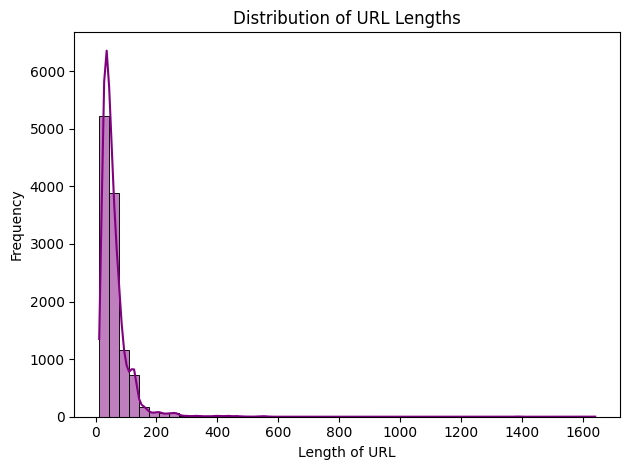

In [22]:
import seaborn as sns
df["url_length"] = df["url"].apply(len)
sns.histplot(df["url_length"], bins=50, kde=True, color="purple")
plt.title("Distribution of URL Lengths")
plt.xlabel("Length of URL")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

<ipython-input-23-c75f0ce387e6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=f1_values, palette="Blues_d")


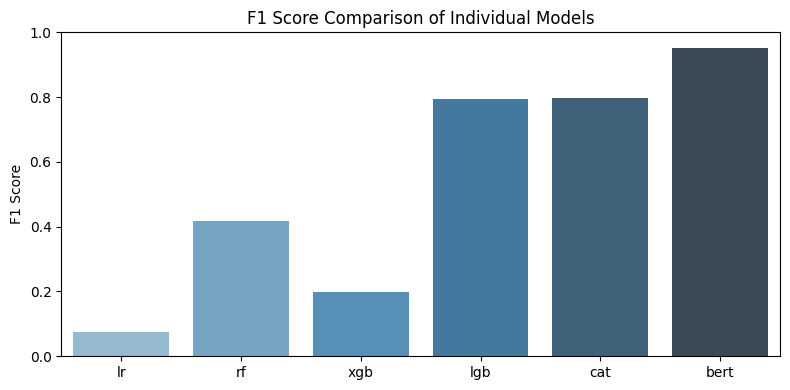

In [23]:


model_names = list(weights.keys())
f1_values = list(weights.values())

plt.figure(figsize=(8, 4))
sns.barplot(x=model_names, y=f1_values, palette="Blues_d")
plt.title("F1 Score Comparison of Individual Models")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()